In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier


In [3]:
train = pd.read_csv('train (2).csv')
test = pd.read_csv('test (2).csv')
train.Churn.value_counts()

Churn
0    3898
1    1384
Name: count, dtype: int64

In [4]:

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [5]:
train.isnull().sum().sort_values(ascending=False)

ClientPeriod                0
MonthlySpending             0
PaymentMethod               0
IsBillingPaperless          0
HasContractPhone            0
HasMovieSubscription        0
HasOnlineTV                 0
HasTechSupportAccess        0
HasDeviceProtection         0
HasOnlineBackup             0
HasOnlineSecurityService    0
HasInternetService          0
HasMultiplePhoneNumbers     0
HasPhoneService             0
HasChild                    0
HasPartner                  0
IsSeniorCitizen             0
Sex                         0
TotalSpent                  0
Churn                       0
dtype: int64

<Axes: >

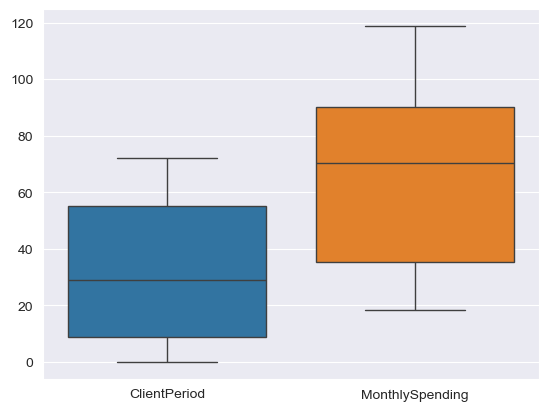

In [6]:
sns.boxplot(train[num_cols])

In [7]:
train.TotalSpent.dropna(inplace=True)

In [8]:
train.TotalSpent = train.TotalSpent.replace(' ', np.nan)
train.TotalSpent = train.TotalSpent.fillna(0)

In [9]:
train.TotalSpent = train.TotalSpent.astype(float)

<Axes: >

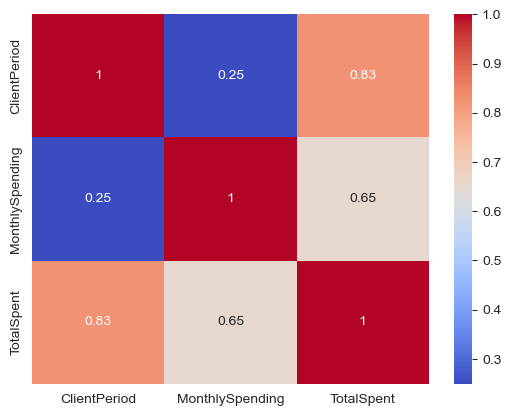

In [10]:
sns.heatmap(train[num_cols].corr(), cmap='coolwarm', annot=True)

In [11]:
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])

In [51]:
X = train.drop('Churn', axis=1)
y = train.Churn
X_train,X_temp,y_train,y_temp = train_test_split(X,y,test_size=0.3,random_state=42)
X_valid,X_test,y_valid,y_test = train_test_split(X_temp,y_temp,test_size=0.5,random_state=42)

In [60]:
model = CatBoostClassifier(
    cat_features = cat_cols,
    logging_level='Silent',
    eval_metric="AUC:hints=skip_train~false",
    random_seed=42,
    task_type="GPU"
)
PARAMS = {
    'l2_leaf_reg': np.arange(0.1, 1, 0.05),
    'n_estimators': [200,300,400,500,600,700],
    'depth': np.arange(1, 10, 1)
}

grid_search_result = model.grid_search(PARAMS, X_train,y_train, cv=3, plot=True)

Default metric period is 5 because AUC is/are not implemented for GPU


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	loss: 0.8378436	best: 0.8378436 (0)	total: 5.24s	remaining: 1h 24m 47s


Default metric period is 5 because AUC is/are not implemented for GPU


1:	loss: 0.8376658	best: 0.8378436 (0)	total: 9.67s	remaining: 1h 18m 8s


Default metric period is 5 because AUC is/are not implemented for GPU


2:	loss: 0.8377297	best: 0.8378436 (0)	total: 13.7s	remaining: 1h 13m 56s


Default metric period is 5 because AUC is/are not implemented for GPU


KeyboardInterrupt: 

In [43]:
grid_search_result['params']

{'depth': 5, 'l2_leaf_reg': 0.30000000000000004, 'iterations': 300}

In [56]:
boosting_clf = CatBoostClassifier(
    # cat_features = cat_cols,
    # logging_level='Silent',
    # eval_metric="AUC:hints=skip_train~false",
    # random_seed=0,
    # depth = 5,
    # l2_leaf_reg = 0.3,
    # iterations = 300
    # dont delite this features, just paste from grid_search_result
)
boosting_clf.fit(X_train,y_train)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=3]="Male": Cannot convert 'b'Male'' to float

In [53]:
pred = boosting_clf.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid,pred)


0.8484939236111111